In [1]:
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
import re
from sklearn import metrics

In [2]:
def clearstring(string):
    string = re.sub('[^A-Za-z0-9 ]+', '', string)
    string = string.split(' ')
    string = filter(None, string)
    string = [y.strip() for y in string]
    string = ' '.join(string)
    return string

list_folder = os.listdir('data')
label = list_folder
label_int = LabelEncoder().fit_transform(label)
outer_string = []; outer_label = []
for i in xrange(len(list_folder)):
    list_file = os.listdir('data/' + list_folder[i])
    strings = []
    for x in xrange(len(list_file)):
        with open('data/' + list_folder[i] + '/' + list_file[x], 'rb') as fopen:
            strings += fopen.read().split('\n')
    strings = filter(None, strings)
    for x in xrange(len(strings)):
        strings[x] = clearstring(strings[x])
    labels = [label_int[i]] * len(strings)
    outer_string += strings
    outer_label += labels
    
dataset = np.array([outer_string, outer_label])
dataset = dataset.T

strings = []
for i in xrange(dataset.shape[0]):
    strings += dataset[i][0].split()
        
strings = list(set(strings))
np.random.shuffle(dataset)

In [3]:
print 'total dimension: ' + str(len(strings))
print 'total sentences: ' + str(dataset.shape[0])

total dimension: 20465
total sentences: 10662


In [4]:
class Model:
    def __init__(self, learning_rate, size_input, size_output, delta):
        self.X = tf.placeholder(tf.float32, (None, size_input))
        self.Y = tf.placeholder(tf.float32, (None, size_output))
        
        w1 = tf.Variable(tf.random_normal([size_input, 2048], stddev = 0.5))
        b1 = tf.Variable(tf.random_normal([2048], stddev = 0.1))
        
        w2 = tf.Variable(tf.random_normal([2048, 784], stddev = 0.5))
        b2 = tf.Variable(tf.random_normal([784], stddev = 0.1))
        
        w3 = tf.Variable(tf.random_normal([784, 784], stddev = 0.5))
        b3 = tf.Variable(tf.random_normal([784], stddev = 0.1))
        
        w4 = tf.Variable(tf.random_normal([784, 100], stddev = 0.5))
        b4 = tf.Variable(tf.random_normal([100], stddev = 0.1))
        
        w5 = tf.Variable(tf.random_normal([100, 100], stddev = 0.5))
        b5 = tf.Variable(tf.random_normal([100], stddev = 0.1))
        
        w6 = tf.Variable(tf.random_normal([100, size_output], stddev = 0.5))
        b6 = tf.Variable(tf.random_normal([size_output], stddev = 0.1))
        
        hidden1 = tf.nn.relu(tf.matmul(self.X, w1) + b1)
        hidden1 = tf.layers.batch_normalization(hidden1)
        hidden1 = tf.nn.dropout(hidden1, 1.0)
        
        hidden2 = tf.nn.relu(tf.matmul(hidden1, w2) + b2)
        hidden2 = tf.layers.batch_normalization(hidden2)
        hidden2 = tf.nn.dropout(hidden2, 1.0)
        
        hidden3 = tf.nn.relu(tf.matmul(hidden2, w3) + b3)
        hidden3 = tf.layers.batch_normalization(hidden3)
        hidden3 = tf.nn.dropout(hidden3, 1.0)
        
        hidden4 = tf.nn.relu(tf.matmul(hidden3, w4) + b4)
        hidden4 = tf.layers.batch_normalization(hidden4)
        hidden4 = tf.nn.dropout(hidden4, 1.0)
        
        hidden5 = tf.nn.relu(tf.matmul(hidden4, w5) + b5)
        hidden5 = tf.layers.batch_normalization(hidden5)
        hidden5 = tf.nn.dropout(hidden5, 1.0)
        
        self.logits = tf.matmul(hidden5, w6) + b6
        
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        self.cost += delta * tf.nn.l2_loss(w1) + delta * tf.nn.l2_loss(w2) + delta * tf.nn.l2_loss(w3) + delta * tf.nn.l2_loss(w4) + delta * tf.nn.l2_loss(w5) + delta * tf.nn.l2_loss(w6)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        

In [5]:
sess = tf.InteractiveSession()
model = Model(0.01, len(strings), len(label), 0.0005)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

train_dataset = dataset[:int(dataset.shape[0] * 0.80), :]
test_dataset = dataset[int(dataset.shape[0] * 0.80):, :]

In [6]:
import time
try:
    saver.restore(sess, "./checkpoint/model.ckpt")
    print "load model.."
except:
    print "start from fresh variables.."

EPOCH = 20
BATCH_SIZE = 256
ACCURACY, ACCURACY_TEST, LOST = [], [], []

for i in xrange(EPOCH):
    total_cost = 0; total_accuracy = 0; last_time = time.time()
    
    for x in xrange(0, (train_dataset.shape[0] // BATCH_SIZE) * BATCH_SIZE, BATCH_SIZE):
        batch_x = np.zeros((BATCH_SIZE, len(strings)))
        batch_y = np.zeros((BATCH_SIZE, len(label)))
        
        for k in xrange(BATCH_SIZE):
            for _, text in enumerate(train_dataset[x + k, 0].split()):
                try:
                    batch_x[k, strings.index(text)] += 1.0
                except:
                    continue
            
            batch_y[k, int(train_dataset[x + k, 1])] = 1.0
        
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X : batch_x, model.Y : batch_y})
        total_accuracy += sess.run(model.accuracy, feed_dict = {model.X : batch_x, model.Y : batch_y})
        total_cost += loss
            
    diff = time.time() - last_time
    total_accuracy /= (train_dataset.shape[0] // BATCH_SIZE)
    total_cost /= (train_dataset.shape[0] // BATCH_SIZE)
    ACCURACY.append(total_accuracy)
    LOST.append(total_cost)
    
    print "total accuracy during training: " + str(total_accuracy)
    print "epoch: " + str(i + 1) + ", loss: " + str(total_cost) + ", speed: " + str(diff / (train_dataset.shape[0] // BATCH_SIZE)) + " s / batch"
    
    batch_x = np.zeros((test_dataset.shape[0], len(strings)))
    batch_y = np.zeros((test_dataset.shape[0], len(label)))
    for k in xrange(test_dataset.shape[0]):
        for _, text in enumerate(test_dataset[k, 0].split()):
            try:
                batch_x[k, strings.index(text)] += 1.0
            except:
                continue
        batch_y[k, int(test_dataset[k, 1])] = 1.0
    accuracy_test = sess.run(model.accuracy, feed_dict = {model.X : batch_x, model.Y : batch_y})
    ACCURACY_TEST.append(accuracy_test)
    print "total accuracy during testing: " + str(accuracy_test)
    
    if(i + 1) % 5 == 0:
        batch_x = np.zeros((test_dataset.shape[0], len(strings)))
        for k in xrange(test_dataset.shape[0]):
            for _, text in enumerate(test_dataset[k, 0].split()):
                try:
                    batch_x[k, strings.index(text)] += 1.0
                except:
                    continue
        logits = sess.run(tf.cast(tf.argmax(model.logits, 1), tf.int32), feed_dict = {model.X : batch_x})
        print(metrics.classification_report(test_dataset[:, 1].astype(int), logits, target_names = ['negative', 'positive']))
    
    saver.save(sess, "./checkpoint/model.ckpt")

INFO:tensorflow:Restoring parameters from ./checkpoint/model.ckpt
start from fresh variables..
total accuracy during training: 0.544744318182
epoch: 1, loss: 16326.4958126, speed: 0.642724672953 s / batch
total accuracy during testing: 0.503047
total accuracy during training: 0.725852272727
epoch: 2, loss: 2299.14193818, speed: 0.637166514541 s / batch
total accuracy during testing: 0.679794
total accuracy during training: 0.897135416667
epoch: 3, loss: 1166.9354248, speed: 0.635677055879 s / batch
total accuracy during testing: 0.73699
total accuracy during training: 0.979521780303
epoch: 4, loss: 945.682428533, speed: 0.63682530143 s / batch
total accuracy during testing: 0.73699
total accuracy during training: 0.998106060606
epoch: 5, loss: 894.145197088, speed: 0.635346390984 s / batch
total accuracy during testing: 0.732302
             precision    recall  f1-score   support

   negative       0.78      0.65      0.71      1070
   positive       0.70      0.81      0.75      1063

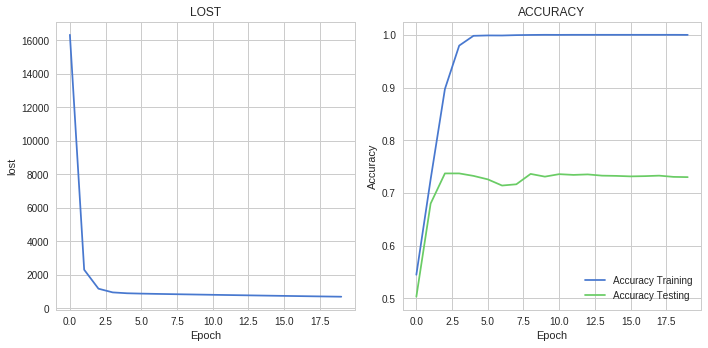

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid", palette = "muted")
fig = plt.figure(figsize = (10, 5))
    
plt.subplot(1, 2, 1)

x = [i for i in xrange(len(LOST))]
    
plt.plot(x, LOST)
plt.xlabel('Epoch')
plt.ylabel('lost')
plt.title('LOST')
    
plt.subplot(1, 2, 2)
    
plt.plot(x, ACCURACY, label = 'Accuracy Training')
plt.plot(x, ACCURACY_TEST, label = 'Accuracy Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ACCURACY')
    
fig.tight_layout()
plt.savefig('graph.png')
plt.savefig('graph.pdf')
plt.show()

In [8]:
from sklearn.preprocessing import Normalizer
strings_list = ['i fucking love you but at the same time i fucking hate you very much',
           'A boy in China conducted an experiment \"I\'m gay, would you hug me?\"',
           'How to exploit a vulnerable door handle by @klepas at our Locksport meet today',
           'Sometime i just feel like when you just copy happy birthday message,it just feel like you dont really mean it',
            'simplistic , silly and tedious .',
            'not so much farcical as sour .',
            'this is a film well worth seeing',
            'a masterpiece four years in the making . ']

for string in strings_list:
    batch_x = np.zeros((1, len(strings)))
    string = clearstring(string = string)
    for _, text in enumerate(string.split()):
        try:
            batch_x[0, strings.index(text)] += 1.0
        except:
            continue

    outputs = sess.run(model.logits, feed_dict = {model.X : batch_x})
    print 'output: ' + str(outputs)
    x =  Normalizer().fit_transform(outputs)
    print 'Normalized: ' + str(x)
    print sess.run(tf.nn.softmax(x))
    print sess.run(tf.nn.softmax(model.logits), feed_dict = {model.X : batch_x})

output: [[-8268.42285156 -7917.85742188]]
Normalized: [[-0.72225207 -0.69162995]]
[[ 0.49234509  0.50765496]]
[[ 0.  1.]]
output: [[-6480.6015625  -6263.32080078]]
Normalized: [[-0.71905822 -0.69494975]]
[[ 0.49397317  0.5060268 ]]
[[ 0.  1.]]
output: [[-5758.66894531 -6517.34814453]]
Normalized: [[-0.66214305 -0.74937743]]
[[ 0.5217948   0.47820523]]
[[ 1.  0.]]
output: [[-10621.51464844 -11587.71972656]]
Normalized: [[-0.67570519 -0.73717195]]
[[ 0.51536185  0.48463815]]
[[ 1.  0.]]
output: [[-2539.11328125 -4645.60351562]]
Normalized: [[-0.47960135 -0.87748653]]
[[ 0.59817946  0.40182057]]
[[ 1.  0.]]
output: [[-3734.38256836 -6954.15429688]]
Normalized: [[-0.4731015  -0.88100797]]
[[ 0.60058576  0.39941421]]
[[ 1.  0.]]
output: [[-7356.93554688 -5659.93994141]]
Normalized: [[-0.79258448 -0.60976213]]
[[ 0.45442131  0.54557872]]
[[ 0.  1.]]
output: [[-10697.99902344  -8915.23339844]]
Normalized: [[-0.76821297 -0.6401943 ]]
[[ 0.46803895  0.53196102]]
[[ 0.  1.]]
